<center><h1>ML4V Project : Image <-> Text models</h1></center>
<center><h2>Student: Mohamed Ben Ali</h2></center>

---------------------------------

Nous avons investigué précédemment comment on pourrait implémenter un modèle Encodeur Image - décodeur Texte pour la tâche d'Image Captioning, qui pourrait servir dans plusieurs application (captioning de publications, d'articles dans les site E-commerce, dans une API pour les gense avec des troubles visuels etc.).

Quand on travaille avec les **texte** et **l'image**, on n'a pas que l'Image captioning (Image to text retrieval) comme possibilité, mais on peut aussi penser à trois (3) autres tâches:
* **Texte to Image retrieval:** La possibilité d'obtenir une image étant donné un texte (une caption, une requête)
* **Text to Text retrieval:** La possibilité d'obtenir ou de générer du texte en réponse à un texte donné, ou similair à celui-ci.
* **Image to Image retrieval:** La possibilité de donner une image en fournissant au modèle une image similaire.

Ces quatres tâches regroupées constituent un outil très attirant aux entreprises, exemple:
Chatbot conversationnel auquel on peut donner une image similaire au produit qu'on veut acheter (***I2I***), qui peut converser avec les clients (***T2T***), qui peut récupérer un produit à partir du message du client (***T2I***) et qui peut améliorer les descriptions des produits (***I2T***).

Il s'agit d'un exemple important de Machine Learning en action, la mission dans ce projet est d'implémenter un Dual Encoder Text-Image avec une constractive loss Multi-Task. Pour explorer les performances, on testera sur la tâche T2I, et I2T où dans ce cas le modèle image sera ré-entraîné avec un décodeur de texte.

* [Création de dataset](#data_create)
  *  [Génération du vocabulaire](#vocab)
  *  [Création du dataset text-image FlickrDataset](#data_ti)
* [Dual Encoder Text-Image](#DE)
  *  [Implémentation du Modèle Image](#DE_img)
  *  [Implémentation du Modèle Texte](#DE_txt)
  *  [Implémentation de la fonction loss](#DE_loss)
  *  [Entraînement du modèle sur FlickrDataset](##DE_ent_val)
  *  [Test du modèle sur T2I et I2I](#DE_test)

* [Encoder-Decoder Image-Text](#retraining-encoder-decoder-on-flickr)
  *  [Implémentation du Modèle décodeur Text](#implémentation-du-décodeur-texte)
  *  [Implémentation de la fonction loss](#implémentation-de-la-fonction-loss)
  *  [Entraînement du modèle sur FlickrDataset](#entraînement-encoder-decoder-sur-le-dataset-flickr)
  *  [Test du modèle sur I2T](#test-du-modèle-sur-i2t)

* [Prochaines étapes](#prochaines-étapes)


# Imports et téléchargement du dataset

On télécharge les images avec cette ligne de code, mais le fichier json avec la répartition de Karpathy doit être téléchargé du site officiel: https://cs.stanford.edu/people/karpathy/deepimagesent/ (35MB pour coco, f8k et f30k)

In [ ]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!unzip -qq Flickr8k_Dataset.zip

In [ ]:
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
import os
import nltk
from PIL import Image
import numpy as np
import json as jsonmod
from tqdm import tqdm
import matplotlib.pyplot as plt
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Création du dataset d'entraînement <a name="data_create"></a>
## Génération du vocabulaire <a name="vocab"></a>

Nous commençons par générer le vocabulaire qui passera sur les captions du dataset pour générer un vocabulaire, i.e un dictionnaire où pour chaque mot nous avons un identifiant, pour chaque identifiant on peut récupérer le mot correspondant. On y ajoute aussi les identifiants de < pad> (padding de 0), < unk> (mot n'apparaît pas dans le vocabulaire du modèle) et < start>, < end> (début et fin d'une phrase). Le code est sauvegardé dans le fichier vocab.py dans il suffit d'exécuter la ligne de code suivant, qui suppose la sauvegarde du fichier .json ```dataset_flickr8k.json``` dans le dossier ```f8k``` (ou ```dataset_flickr30k.json``` dans ```f30k/```). Le fichier en sortie est déjà sauvegardé dans ce dossier  ```f8k_vocab.pkl```

In [ ]:
!python vocab.py --data_path drive/MyDrive --data_name f8k

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[0/40000] tokenized the captions.
[1000/40000] tokenized the captions.
[2000/40000] tokenized the captions.
[3000/40000] tokenized the captions.
[4000/40000] tokenized the captions.
[5000/40000] tokenized the captions.
[6000/40000] tokenized the captions.
[7000/40000] tokenized the captions.
[8000/40000] tokenized the captions.
[9000/40000] tokenized the captions.
[10000/40000] tokenized the captions.
[11000/40000] tokenized the captions.
[12000/40000] tokenized the captions.
[13000/40000] tokenized the captions.
[14000/40000] tokenized the captions.
[15000/40000] tokenized the captions.
[16000/40000] tokenized the captions.
[17000/40000] tokenized the captions.
[18000/40000] tokenized the captions.
[19000/40000] tokenized the captions.
[20000/40000] tokenized the captions.
[21000/40000] tokenized the captions.
[22000/40000] tokenized the captions.
[23000/40000] tokenized the capti

## Création du dataset Text-Imge <a class="anchor" id="data_ti"></a>
#### Récupération de l'ensemble des chemins d'images et les captions correspondantes:

In [ ]:
def get_paths(path_cap, imgdir, name='f8k', use_restval=False):
    roots = {}
    ids = {}
    if 'f8k' == name:
        cap = os.path.join(path_cap, 'dataset_flickr8k.json')
        roots['train'] = {'img': imgdir, 'cap': cap}
        roots['val'] = {'img': imgdir, 'cap': cap}
        roots['test'] = {'img': imgdir, 'cap': cap}
        ids = {'train': None, 'val': None, 'test': None}
    elif 'f30k' == name:
        cap = os.path.join(path_cap, 'dataset_flickr30k.json')
        roots['train'] = {'img': imgdir, 'cap': cap}
        roots['val'] = {'img': imgdir, 'cap': cap}
        roots['test'] = {'img': imgdir, 'cap': cap}
        ids = {'train': None, 'val': None, 'test': None}

    return roots, ids

#### Transformation des images:
Cette fonction peut être donnée au DataLoader pour générer les batches du dataset de training et de validation. Vu qu'on utilisera des modèles pré-entraînés, cette fonction les mettra les images dans le bon format d'entrées de ceux-ci, on y ajoute aussi un random flip et random sized crop comme augmentation de données:

In [ ]:
def get_transform(data_name, split_name, crop_size):
    normalizer = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])
    t_list = []
    if split_name == 'train':
        t_list = [transforms.RandomResizedCrop(crop_size),
                  transforms.RandomHorizontalFlip()]
    elif split_name == 'val':
        t_list = [transforms.Resize(256), transforms.CenterCrop(224)]
    elif split_name == 'test':
        t_list = [transforms.Resize(256), transforms.CenterCrop(224)]

    t_end = [transforms.ToTensor(), normalizer]
    transform = transforms.Compose(t_list + t_end)
    return transform

In [ ]:
class FlickrDataset(data.Dataset):
    """
    Dataset loader for Flickr30k and Flickr8k full datasets.
    """

    def __init__(self, root, json, split, vocab, transform=None):
        self.root = root
        self.vocab = vocab
        self.split = split
        self.transform = transform
        self.dataset = jsonmod.load(open(json, 'r'))['images']
        self.ids = []
        for i, d in enumerate(self.dataset):
            if d['split'] == split:
                self.ids += [(i, x) for x in range(len(d['sentences']))]

    def __getitem__(self, index):
        """This function returns a tuple that is further passed to collate_fn
        """
        vocab = self.vocab
        root = self.root
        ann_id = self.ids[index]
        img_id = ann_id[0]
        caption = self.dataset[img_id]['sentences'][ann_id[1]]['raw']
        path = self.dataset[img_id]['filename']

        image = Image.open(os.path.join(root, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        # Convert caption (string) to word ids.
        tokens = nltk.tokenize.word_tokenize(
            str(caption).lower())
        caption = []
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target, index, img_id

    def __len__(self):
        return len(self.ids)

In [ ]:
def collate_fn(data):
    """Build mini-batch tensors from a list of (image, caption) tuples.
    Args:
        data: list of (image, caption) tuple.
            - image: torch tensor of shape (3, 224, 224).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 224, 224).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions, ids, img_ids = zip(*data)

    # Merge images (convert tuple of 3D tensor to 4D tensor)
    images = torch.stack(images, 0)

    # Merget captions (convert tuple of 1D tensor to 2D tensor)
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]

    return images, targets, lengths, ids

# Image-Text Dual Encoder with Multi-Task Learning <a class="anchor" id="DE"></a>
Dans cette partie nous implémentons notre modèle principal, Avec un encodeur uni-modalité de chaque côté, on peut créer des embeddings cross-modalités.

La fonction loss constractive va permet de rapprocher de chaque image (ou texte) l'exemple correspondant par rapport aux autres exemples. Nous y ajouterons une loss entre images et entre textes pour renforcer la sélectivité du modèle. En effet, selon des travaux précédent (notamment le mini-projet du module précédent) l'encodeur basé sur VGG19 donnait toujours de bons scores (de l'ordre d'une similarité de 0.99).

In [ ]:
import torch
import torch.nn as nn
import torch.nn.init
import torchvision.models as models
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.backends.cudnn as cudnn
import numpy as np
from collections import OrderedDict


def l2norm(X):
    """L2-normalize columns of X
    """
    norm = torch.pow(X, 2).sum(dim=1, keepdim=True).sqrt()
    X = torch.div(X, norm)
    return X

def cosine_sim(im, s):
    """Cosine similarity between all the image and sentence pairs
    """
    return im.mm(s.t())


def order_sim(im, s):
    """Order embeddings similarity measure $max(0, s-im)$
    """
    YmX = (s.unsqueeze(1).expand(s.size(0), im.size(0), s.size(1))
           - im.unsqueeze(0).expand(s.size(0), im.size(0), s.size(1)))
    score = -YmX.clamp(min=0).pow(2).sum(2).sqrt().t()
    return score

## Implémentation de l'encodeur image: <a class="anchor" id="DE_img"></a>
L'encodeur image est un simple modèle basé sur un modèle pré-entraîné, ici on peut choisir entre les modèles vgg et les modèles resnet. D'après l'article sur CrissCrossed Captions, Resnet et InceptionV3 ne donnait pas de bonnes performances donc nous continuerons avec VGG19.

In [ ]:
class EncoderImageFull(nn.Module):

    def __init__(self, embed_size, finetune=False, cnn_type='vgg19',
                 use_abs=False, no_imgnorm=False):
        """Load pretrained VGG19 and replace top fc layer."""
        super(EncoderImageFull, self).__init__()
        self.embed_size = embed_size
        self.no_imgnorm = no_imgnorm
        self.use_abs = use_abs

        # Load a pre-trained model
        self.cnn = self.get_cnn(cnn_type, True)

        # For efficient memory usage.
        for param in self.cnn.parameters():
            param.requires_grad = finetune

        # Replace the last fully connected layer of CNN with a new one
        if cnn_type.startswith('vgg'):
            self.fc = nn.Linear(self.cnn.classifier._modules['6'].in_features,
                                embed_size)
            self.cnn.classifier = nn.Sequential(
                *list(self.cnn.classifier.children())[:-1])
        elif cnn_type.startswith('resnet'):
            self.fc = nn.Linear(self.cnn.module.fc.in_features, embed_size)
            self.cnn.module.fc = nn.Sequential()

        self.init_weights()

    def get_cnn(self, arch, pretrained):
        """Load a pretrained CNN and parallelize over GPUs
        """
        if pretrained:
            print("=> using pre-trained model '{}'".format(arch))
            model = models.__dict__[arch](pretrained=True)
        else:
            print("=> creating model '{}'".format(arch))
            model = models.__dict__[arch]()

        if arch.startswith('alexnet') or arch.startswith('vgg'):
            model.features = nn.DataParallel(model.features)
            model.cuda()
        else:
            model = nn.DataParallel(model).cuda()

        return model

    def init_weights(self):
        """Xavier initialization for the fully connected layer
        """
        r = np.sqrt(6.) / np.sqrt(self.fc.in_features +
                                  self.fc.out_features)
        self.fc.weight.data.uniform_(-r, r)
        self.fc.bias.data.fill_(0)

    def forward(self, images):
        """Extract image feature vectors."""
        features = self.cnn(images)

        # normalization in the image embedding space
        features = l2norm(features)

        # linear projection to the joint embedding space
        features = self.fc(features)

        # normalization in the joint embedding space
        if not self.no_imgnorm:
            features = l2norm(features)

        # take the absolute value of the embedding (used in order embeddings)
        if self.use_abs:
            features = torch.abs(features)

        return features


## Implémentation de l'encodeur texte: <a class="anchor" id="DE_txt"></a>
L'encodeur texte est un GRU pour la projection dans l'embedding partagé avec les images, cette structure a été adoptée en VSRN et VSE++.

On pourrait ajouter des couches linéaire pour permettre une meilleure projection et changer l'encodeur par un modèle pré-entraîné (BERT, ou CLIP) mais il faudra que le type d'entraînement soit compatible avec celui de l'encodeur des images.

In [ ]:
class EncoderText(nn.Module):

    def __init__(self, vocab_size, word_dim, embed_size, num_layers,
                 use_abs=False):
        super(EncoderText, self).__init__()
        self.use_abs = use_abs
        self.embed_size = embed_size

        # word embedding
        self.embed = nn.Embedding(vocab_size, word_dim)

        # caption embedding
        self.rnn = nn.GRU(word_dim, embed_size, num_layers, batch_first=True)

        self.init_weights()

    def init_weights(self):
        self.embed.weight.data.uniform_(-0.1, 0.1)

    def forward(self, x, lengths):
        """Handles variable size captions
        """
        # Embed word ids to vectors
        x = self.embed(x)
        packed = pack_padded_sequence(x, lengths, batch_first=True)

        # Forward propagate RNN
        out, _ = self.rnn(packed)

        # Reshape *final* output to (batch_size, hidden_size)
        padded = pad_packed_sequence(out, batch_first=True)
        I = torch.LongTensor(lengths).view(-1, 1, 1)
        I = Variable(I.expand(x.size(0), 1, self.embed_size)-1).cuda()
        out = torch.gather(padded[0], 1, I).squeeze(1)

        # normalization in the joint embedding space
        out = l2norm(out)

        # take absolute value, used by order embeddings
        if self.use_abs:
            out = torch.abs(out)

        return out

## Implémentation de la fonction loss <a class="anchor" id="DE_loss"></a>
La fonction loss suivante permet d'organiser l'embedding des images par rapport à celui des textes et vice-versa. Pour chaque élément (e.g image), l'élément correspondant dans la matrice des encodages de textes doit être le plus proches en termes de similarité à l'image. Cette loss calcule les deux sens en même temps.

In [ ]:
class ContrastiveLoss(nn.Module):
    """
    Compute contrastive loss
    """

    def __init__(self, margin=0, measure=False, max_violation=False):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        if measure == 'order':
            self.sim = order_sim
        else:
            self.sim = cosine_sim

        self.max_violation = max_violation

    def forward(self, im, s):
        # compute image-sentence score matrix
        scores = self.sim(im, s)
        diagonal = scores.diag().view(im.size(0), 1)
        d1 = diagonal.expand_as(scores)
        d2 = diagonal.t().expand_as(scores)

        # compare every diagonal score to scores in its column
        # caption retrieval
        cost_s = (self.margin + scores - d1).clamp(min=0)
        # compare every diagonal score to scores in its row
        # image retrieval
        cost_im = (self.margin + scores - d2).clamp(min=0)

        # clear diagonals
        mask = torch.eye(scores.size(0)) > .5
        I = Variable(mask)
        if torch.cuda.is_available():
            I = I.cuda()
        cost_s = cost_s.masked_fill_(I, 0)
        cost_im = cost_im.masked_fill_(I, 0)

        # keep the maximum violating negative for each query
        if self.max_violation:
            cost_s = cost_s.max(1)[0]
            cost_im = cost_im.max(0)[0]

        return cost_s.sum() + cost_im.sum()

## Entraînement et validation du Dual Encoder <a class="anchor" id="DE_ent_val"></a>
Le modèle sera entraîné avec une loss pondérée entre Texte-Images et Texte-Texte et Image-Image avec une plus grande importance aux tâches cross-modalités.

In [ ]:
def train(train_loader, img_enc, txt_enc, loss_func):

    # switch to train mode
    img_enc.train()
    txt_enc.train()
    loss_t = 0
    for i, (images, captions, lengths, ids) in enumerate(tqdm(train_loader)):

        images = Variable(images)
        captions = Variable(captions)
        if torch.cuda.is_available():
            images = images.cuda()
            captions = captions.cuda()
        # Forward
        img_emb = img_enc(images)
        cap_emb = txt_enc(captions, lengths)
        # measure accuracy and record loss
        optimizer.zero_grad()
        loss = 0.8*loss_func(img_emb, cap_emb) + 0.1*loss_func(img_emb, img_emb) + 0.1*loss_func(cap_emb, cap_emb)
        loss_t += loss
        # compute gradient and do SGD step
        loss.backward()
        optimizer.step()


    return loss_t/len(train_loader)

In [ ]:
def validate(val_loader, img_enc, txt_enc, loss_func):

    # switch to train mode
    img_enc.eval()
    txt_enc.eval()
    loss = 0
    for i, (images, captions, lengths, ids) in enumerate(val_loader):

        images = Variable(images)
        captions = Variable(captions)
        if torch.cuda.is_available():
            images = images.cuda()
            captions = captions.cuda()
        # Forward
        img_emb = img_enc(images)
        cap_emb = txt_enc(captions, lengths)
        loss += 0.8*loss_func(img_emb, cap_emb) + 0.1*loss_func(img_emb, img_emb) + 0.1*loss_func(cap_emb, cap_emb)
    return loss/len(val_loader)

# Settings

On récupère les dataset d'entraînement et de validation avec les dataloader

In [ ]:
import pickle
from vocab import Vocabulary  # NOQA

vocab = pickle.load(open("f8k_vocab.pkl", 'rb'))
roots, ids = get_paths(path_cap="drive/MyDrive/f8k", imgdir="Flicker8k_Dataset/")

transform = get_transform("f8k", 'train', 224)

f8k_train_dataset = FlickrDataset(root=roots['train']['img'],
                                split="train",
                                json=roots['train']['cap'],
                                vocab=vocab,
                                transform=transform)

transform = get_transform("f8k", 'val', 224)
f8k_val_dataset = FlickrDataset(root=roots['val']['img'],
                                split="val",
                                json=roots['val']['cap'],
                                vocab=vocab,
                                transform=transform)

In [ ]:
word_dim = 300
embedding_dim =  256

train_loader = torch.utils.data.DataLoader(dataset=f8k_train_dataset,
                                              batch_size=128,
                                              shuffle=True,
                                              pin_memory=True,
                                              num_workers=0,
                                              collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(dataset=f8k_val_dataset,
                                              batch_size=128,
                                              shuffle=True,
                                              pin_memory=True,
                                              num_workers=0,
                                              collate_fn=collate_fn)

On initialize les encodeurs texte et images avec l'optimizer, ici on ne finetune pas les paramètres de VGG19 car cela prendra beaucoup plus de temps donc les paramètres de l'optimizer sont réduits à l'encodeur de texte et les couches linéaires de l'encodeur des images:

In [ ]:
txt_enc = EncoderText(len(vocab), word_dim=word_dim, embed_size=embedding_dim, num_layers=1)
img_enc = EncoderImageFull(embed_size=embedding_dim)
num_epochs = 10

params = list(txt_enc.parameters()) + list(img_enc.fc.parameters())
optimizer = torch.optim.Adam(params, lr=0.0001)

=> using pre-trained model 'vgg19'


In [ ]:
# Training
best_rsum = 0
loss_func = ContrastiveLoss()
if torch.cuda.is_available():
    img_enc.cuda()
    txt_enc.cuda()
    cudnn.benchmark = True

loss_train, loss_val = [], []
for epoch in range(num_epochs):

    # train for one epoch
    loss = train(train_loader, img_enc, txt_enc,loss_func=loss_func)
    loss_train.append(loss.data.cpu().numpy())
    # evaluate on validation set
    loss_v = validate(val_loader, img_enc, txt_enc,loss_func=loss_func)
    loss_val.append(loss_v.data.cpu().numpy())

    print(f"Epoch: {epoch+1}/{num_epochs}: loss on training {loss}, loss on validation: {loss_v}")

100%|██████████| 235/235 [07:46<00:00,  1.98s/it]


Epoch: 1/10: loss on training 141.1585235595703, loss on validation: 24.725610733032227


100%|██████████| 235/235 [07:34<00:00,  1.93s/it]


Epoch: 2/10: loss on training 25.094511032104492, loss on validation: 14.438179016113281


100%|██████████| 235/235 [07:34<00:00,  1.93s/it]


Epoch: 3/10: loss on training 16.612314224243164, loss on validation: 10.68008041381836


100%|██████████| 235/235 [07:35<00:00,  1.94s/it]


Epoch: 4/10: loss on training 12.475425720214844, loss on validation: 8.578405380249023


100%|██████████| 235/235 [07:31<00:00,  1.92s/it]


Epoch: 5/10: loss on training 9.759491920471191, loss on validation: 6.451822757720947


100%|██████████| 235/235 [07:31<00:00,  1.92s/it]


Epoch: 6/10: loss on training 7.821661949157715, loss on validation: 4.985820293426514


100%|██████████| 235/235 [07:32<00:00,  1.93s/it]


Epoch: 7/10: loss on training 6.503244400024414, loss on validation: 4.156864166259766


100%|██████████| 235/235 [07:30<00:00,  1.92s/it]


Epoch: 8/10: loss on training 5.552464962005615, loss on validation: 4.395585536956787


100%|██████████| 235/235 [07:33<00:00,  1.93s/it]


Epoch: 9/10: loss on training 4.961019515991211, loss on validation: 3.3615901470184326


100%|██████████| 235/235 [07:36<00:00,  1.94s/it]


Epoch: 10/10: loss on training 4.380402565002441, loss on validation: 3.1835124492645264


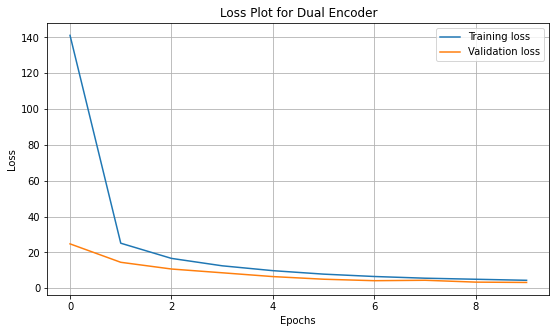

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 5))
plt.plot(loss_train, label='Training loss')
plt.plot(loss_val, label="Validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot for Dual Encoder')
plt.grid()
plt.legend()
plt.show()

La fonction loss sur la validation et sur l'entraînement descent bien sans fluctuation et se stabilise après 6 epochs, donc on peut passer à la partie évaluation du modèle:

In [ ]:
torch.save(img_enc, "Image_encoder.pth")
torch.save(txt_enc, "Texte_encoder.pth")

## Test du modèle sur I2I et T2I

In [ ]:
image_enc = torch.load("Image_encoder.pth")
texte_enc = torch.load("Image_encoder.pth")

In [ ]:
img_embs = None
all_ids = np.zeros(len(val_loader.dataset))
for i, (images, captions, lengths, ids) in enumerate(tqdm(val_loader)):

    images = Variable(images)
    if torch.cuda.is_available():
        images = images.cuda()
    # Forward
    img_emb = image_enc(images)
    if img_embs is None:
            img_embs = np.zeros((len(val_loader.dataset), img_emb.size(1)))

    # preserve the embeddings by copying from gpu and converting to numpy
    img_embs[ids] = img_emb.data.cpu().numpy().copy()

100%|██████████| 40/40 [01:38<00:00,  2.46s/it]


### I2I retrieval:
On se met dans la situation où on donne au modèle une image et on veut qu'il nous propose une image similaire, pour ce faire on a encodé un ensemble d'images (avec la contrainte de mémoire on a utilisé le dataset de validation) et on fournit une image qui sera aussi encodé et placé dans l'embedding pour récupérer l'élément le plus proche.

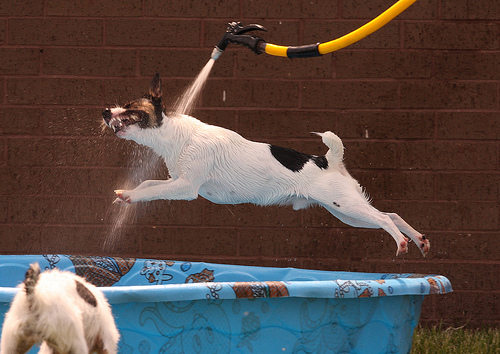

In [ ]:
rid = np.random.randint(0,4000)
list_names = os.listdir("Flicker8k_Dataset/")
image = list_names[rid]
image_path = os.path.join("Flicker8k_Dataset/", image)
image = Image.open(image_path).convert('RGB')
transform = get_transform("f8k", 'val', 224)
image = transform(image)
img_emb = image_enc(torch.unsqueeze(image, 0)).data.cpu().numpy()
scores = np.argsort(np.dot(img_emb,img_embs.T)).flatten()[::-1]
Image.open(image_path)

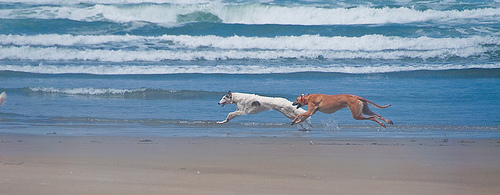

In [ ]:
data_json = jsonmod.load(open("drive/MyDrive/f8k/dataset_flickr8k.json", 'r'))['images']
path = data_json[scores[-1]]['filename']
Image.open(os.path.join("Flicker8k_Dataset/", path)).convert('RGB')

Bien que les images sont similaires, on peut voir que le modèle doit encore s'entraîner sur plus d'images et sur plus d'étapes d'entraînement!

### T2I retrieval
Cette tâche est bien plus simple que la tâche miroire (I2T), nous essayons pas de générer un élément mais de récupérer l'élément le plus proche parmi les .

Bien entendu, on peut faire de même pour I2T et T2T et chercher parmi les captions disponibles mais cette fonctionalité est très limitée et ne peut pas être généralisée.

In [ ]:
caption = "A player spiking the ball"
tokens = nltk.tokenize.word_tokenize(
    str(caption).lower())
caption = []
caption.append(vocab('<start>'))
caption.extend([vocab(token) for token in tokens])
caption.append(vocab('<end>'))
target = torch.tensor(caption)
cap_emb = txt_enc(torch.unsqueeze(target.cuda(), 0), [len(target)]).data.cpu().numpy()
scores = np.argsort(np.dot(cap_emb,img_embs.transpose()), axis=1)[0][::-1]

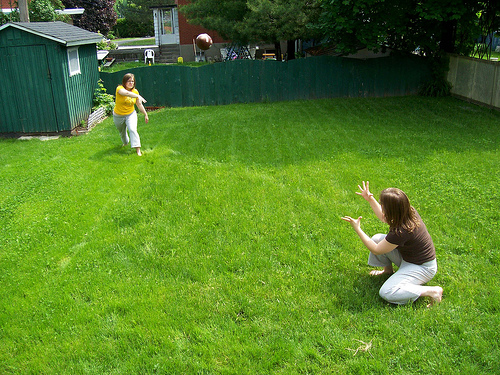

In [ ]:
data_json = jsonmod.load(open("drive/MyDrive/f8k/dataset_flickr8k.json", 'r'))['images']
path = data_json[scores[0]]['filename']
Image.open(os.path.join("Flicker8k_Dataset/", path)).convert('RGB')

Pour la caption ``player spiking the ball`` on a une image qui ressemble à ce qu'on veut vu que la personne spike la balle, mais on s'attendait à avoir un joueur de volleyball dans le terrain. Ici, c'est possible que la longueur de la caption contribue dans la qualité des prédiction.

# Retraining Encoder-Decoder on Flickr
On garde le même encodeur d'images et on reprend la structure du décodeur vu en TP avec l'attention et un RNN de type GRU comme l'encodeur implémenté précédemment, avec une loss crossentropy pour comparer les texte généré avec le texte correspondant à l'image d'entrée.

In [ ]:
class BahdanauAttention(nn.Module):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = nn.Linear(embedding_dim, units)
    self.W2 = nn.Linear(units, units)
    self.V = nn.Linear(units, 1)

  def forward(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = torch.unsqueeze(hidden, 1)

    # score shape == (batch_size, hidden_size)
    score = torch.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = torch.softmax(self.V(score), dim=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = torch.sum(context_vector, dim=1)

    return context_vector, attention_weights

## Implémentation du décodeur Texte:

In [ ]:
class DecoderText(nn.Module):
  def __init__(self, embedding_dim, units, vocab_size):
    super(DecoderText, self).__init__()
    self.units = units

    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.gru = nn.GRU(self.units, self.units, batch_first=True)
    self.fc1 = nn.Linear(self.units, self.units)
    self.fc2 = nn.Linear(self.units, vocab_size)

    self.attention = BahdanauAttention(self.units)
    if torch.cuda.is_available():
        self.attention.cuda()
        cudnn.benchmark = True
  def forward(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)
    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = torch.cat([torch.unsqueeze(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)
    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = torch.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state

  def reset_state(self, batch_size):
    return torch.zeros((batch_size, self.units))

## Implementation de la fonction loss
Cette fonction compare la génération avec la ground truth et ne prendra pas en compte les génération liées au padding.

In [ ]:
class CaptioningLoss(nn.Module):
    """
    Compute Image captioning loss
    """

    def __init__(self):
        super(CaptioningLoss, self).__init__()
        self.loss_cross_ent = nn.CrossEntropyLoss(reduction="none")

    def forward(self, real, pred):
      mask = torch.where(real != 0, 1, 0)

      loss_ = self.loss_cross_ent(pred, real)
      mask = mask.type(loss_.dtype)
      loss_ *= mask

      return torch.mean(loss_)

In [ ]:
txt_dec = DecoderText(embedding_dim, units=512, vocab_size=len(vocab))
loss_function = CaptioningLoss()
batch_size = 64

params = list(txt_dec.parameters()) + list(img_enc.fc.parameters())
optimizer = torch.optim.Adam(params, lr=0.0001)

## Entraînement Encoder-Decoder sur le dataset Flickr

In [ ]:
# Training
def train_step(img_tensor, target):
  txt_dec.train()
  img_enc.train()
  loss = 0
  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = txt_dec.reset_state(batch_size=target.shape[0])

  dec_input = torch.unsqueeze(torch.tensor([vocab('<start>')] * batch_size, dtype=torch.int64), 1)
  features = img_enc(img_tensor)

  for i in range(1, target.shape[1]):
      # passing the features through the decoder
      if torch.cuda.is_available():
        dec_input = dec_input.cuda()
        hidden = hidden.cuda()
      predictions, hidden = txt_dec(dec_input, features, hidden)
      loss += loss_function(target[:, i], predictions)

      # using teacher forcing
      dec_input = torch.unsqueeze(target[:, i], 1)
      hidden = torch.squeeze(hidden)

  total_loss = (loss / int(target.shape[1]))

  loss.backward()
  optimizer.step()

  return loss, total_loss

In [ ]:
EPOCHS = 10
num_steps = len(train_loader)
loss_plot = []
if torch.cuda.is_available():
    img_enc.cuda()
    txt_dec.cuda()
    cudnn.benchmark = True
for epoch in range(EPOCHS):
    total_loss = 0

    for (batch, (image, target, _, _)) in enumerate(train_loader):
        image = Variable(image)
        target = Variable(target)
        if torch.cuda.is_available():
            image = image.cuda()
            target = target.cuda()
        try:
          batch_loss, t_loss = train_step(image, target)
        except:
          print(image.shape, target.shape)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.data.cpu().numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))

Epoch 1 Batch 0 Loss 2.0046
Epoch 1 Batch 100 Loss 1.7504
Epoch 1 Batch 200 Loss 1.9465
torch.Size([48, 3, 224, 224]) torch.Size([48, 26])
Epoch 1 Loss 2.117310
Epoch 2 Batch 0 Loss 1.9347
Epoch 2 Batch 100 Loss 2.0479
Epoch 2 Batch 200 Loss 1.9052
torch.Size([48, 3, 224, 224]) torch.Size([48, 25])
Epoch 2 Loss 2.062792
Epoch 3 Batch 0 Loss 1.9849
Epoch 3 Batch 100 Loss 2.0370
Epoch 3 Batch 200 Loss 2.0346
torch.Size([48, 3, 224, 224]) torch.Size([48, 24])
Epoch 3 Loss 1.914957
Epoch 4 Batch 0 Loss 1.9692
Epoch 4 Batch 100 Loss 2.0872
Epoch 4 Batch 200 Loss 2.2011
torch.Size([48, 3, 224, 224]) torch.Size([48, 19])
Epoch 4 Loss 1.841115
Epoch 5 Batch 0 Loss 1.8041
Epoch 5 Batch 100 Loss 1.7351
Epoch 5 Batch 200 Loss 2.0462
torch.Size([48, 3, 224, 224]) torch.Size([48, 25])
Epoch 5 Loss 1.788096
Epoch 6 Batch 0 Loss 1.6480
Epoch 6 Batch 100 Loss 1.6093
Epoch 6 Batch 200 Loss 1.8166
torch.Size([48, 3, 224, 224]) torch.Size([48, 22])
Epoch 6 Loss 1.740459
Epoch 7 Batch 0 Loss 1.6164
Epoch 

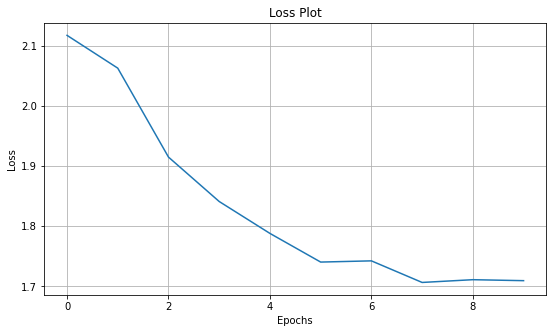

In [ ]:
plt.figure(figsize=(9, 5))
plt.plot([loss.data.cpu().numpy() for loss in loss_plot])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.grid()
plt.show()

La loss descend bien et se stabilize mais n'arrive pas au même niveau obtenu dans le TP. A côté de la possibilité d'un entraînement insuffisant, plusieurs facteurs peuvent contribuer à ce résultat, les dataset d'entraînement et de validation ne sont pas les même et n'ont pas la même taille, le batch size ici est différent et la taille de l'embedding également (2 fois plus grand ce qui demandera plus d'entraînement).

On passe finalement à un test visuel de génération de caption:

## Test du modèle sur I2T:

In [ ]:
max_length = 40
img_enc.eval()
txt_dec.eval()
def evaluate(image):

    hidden = txt_dec.reset_state(batch_size=1)

    features = img_enc(torch.unsqueeze(image, 0))
    dec_input = torch.unsqueeze(torch.tensor([vocab('<start>')], dtype=torch.int64), 0)
    result = []

    for i in range(max_length):
        predictions, hidden = txt_dec(dec_input.cuda(), features, hidden)
        predicted_id = torch.argmax(predictions[0]).cpu().numpy()
        result.append(vocab.idx2word[int(predicted_id)])

        if vocab.idx2word[int(predicted_id)] == '<end>':
            return result

        dec_input = torch.unsqueeze(torch.tensor([int(predicted_id)]), 0)
    return result


3328247381_a9f7fb4898.jpg
torch.Size([3, 224, 224])
Prediction Caption: two people are standing on the water . <end>


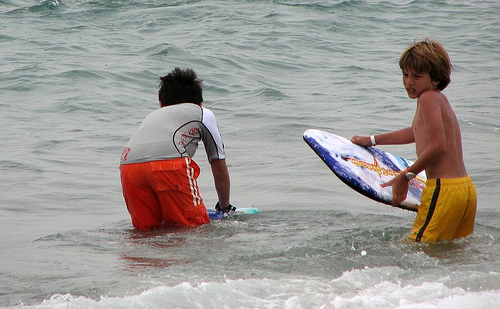

In [ ]:
rid = np.random.randint(0,4000)
list_names = os.listdir("Flicker8k_Dataset/")
image = list_names[rid]
print(image)
image_path = os.path.join("Flicker8k_Dataset/", image)
image = Image.open(image_path).convert('RGB')
transform = get_transform("f8k", 'val', 224)
image = transform(image)
print(image.shape)

result = evaluate(image)
print ('Prediction Caption:', ' '.join(result))
# opening the image
Image.open(image_path)

La prédiction correspond légèrement à l'image donnée mais reste très courte. On attend à avoir plus de description de la scène, au lieu de "Two people" avoir "Two kids" et "holding boards". Flickr a majoritairement des captions courtes ce qui pourrait générer ce type de comportement, on peut envosager travailler avec MS-COCO mais compte tenu des contraintes de mémoire ce projet a été mené sur Flickr.

Si on travaillait que sur l'image captioning, on pourrait se passer du Dual Encoder et entraîner directement un Encoder-Decoder mais ici on a investiguer un modèle cross-modalités qui donnera la possibilité d'avoir un modèle généralisable aux 4 tâches.

# Prochaines étapes:
Nous avons implémenté un modèle simple d'encodage couplé des images et des textes puis nous l'avons étendu à un modèle de génération de textes à partir des images. On peut améliorer notre projet dans différentes façons:

* **Modèle Region-aware:** Les dataset MS-COCO et Flickr ont aussi proposé des captions où les mots correspondent à des bounding box dans l'image, on pourrait penser à un dual-encodeur avec un encodeur image qui prend en compte cette dimension (type FASTER-R-CNN). Les bounding boxes vont être fournies au décodeur séquentiellement au lieu de l'encodage de l'image entière.

* **Transformer based vision encoder:** Au lieu de modèle encodeur séquentiel on peut penser à ajouter des couches de self-attention pour que le modèle d'images se concentre plus sur les régions d'intérêt.

* **Crisscrossed captions:** Nous avons implémenté une fonction coût multi-task mais celle-ci ne fait que augmenter la sélectivité des modèles encodeur uni-modalités. Un article publié sur MS-COCO a ajouté au dataset des ratings entre texte-images, entre image-image et entre texte-texte, ceci permettra une fonction coût multi-task plus robuste.

[1] Parekh, Z., Baldridge, J., Cer, D., Waters, A., & Yang, Y. (2020). Crisscrossed captions: Extended intramodal and intermodal semantic similarity judgments for MS-COCO. arXiv preprint arXiv:2004.15020.

[2] Faghri, F., Fleet, D. J., Kiros, J. R., & Fidler, S. (2017). Vse++: Improving visual-semantic embeddings with hard negatives. arXiv preprint arXiv:1707.05612.

[3] Li, K., Zhang, Y., Li, K., Li, Y., & Fu, Y. (2019). Visual semantic reasoning for image-text matching. In Proceedings of the IEEE/CVF International conference on computer vision (pp. 4654-4662).